Для тестирования кода ниже необходимо скачать следующие файлы:
- http://vectors.nlpl.eu/repository/, модель номер 180.
- файл *output_columns.txt* (или [файл](https://nn.msrabota.ru/content/book_docs/a.s.gavrilova-slovar_sinonimov_i_antonimov_.pdf) со словарем синонимов)

# **Данные и библиотеки**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm.auto import tqdm
from tqdm import tqdm
tqdm.pandas()

In [ ]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import torch.nn.functional as F

In [ ]:
from torch import Tensor
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from sklearn.metrics import jaccard_score

In [ ]:
from transformers import pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pymorphy3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 71.6 MB/s eta 0:00:00


In [ ]:
import pymorphy3
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()

In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download("stopwords")

from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
from string import punctuation

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocessing(text, morph):
    new_text = ''
    lemmas = []
    for sent in sent_tokenize(text, language='russian'):
        words = word_tokenize(sent)
        if words != []:
            for word in words:
                ana = morph.parse(word)[0]
                if 'PNCT' not in ana.tag:
                    new_text += " "  # add space before punctuation
                new_text += ana.normal_form
                lemmas.append(ana.normal_form)
    return new_text.strip(), lemmas

In [ ]:
# первая загрузка, потом сохранила в .pkl
train_df = pd.read_json("train.jsonl", lines=True)
val_df = pd.read_json("val.jsonl", lines=True)
test_df = pd.read_json("test.jsonl", lines=True)

Лейблы датасета - True, False, при этом на трейне классы не сбалансированы, тогда как для val примерно одинаковое количество - смотрели на метрики f1_score и accuracy

In [ ]:
train_df['label'].value_counts()

,count
label,
True,1061
False,688


In [ ]:
val_df['label'].value_counts()

,count
label,
1,412
0,409


<ipython-input-223-a1a84b5c4d01>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


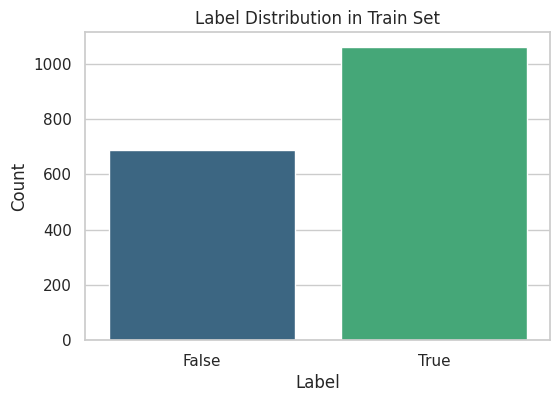

In [ ]:
import pandas as pd
import matplotlib.pyplot
import seaborn as sns

sns.set(style="whitegrid")

def plot_label_distribution(df, title):
    label_counts = df['label'].value_counts()
    plt.figure(figsize=(6, 4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks([0, 1], ['False', 'True'], rotation=0)
    plt.savefig('labels.png')
    plt.show()

# График для train, val и test
plot_label_distribution(train_df, "Label Distribution in Train Set")

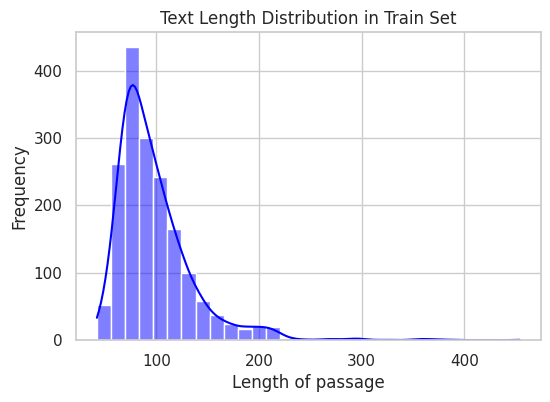

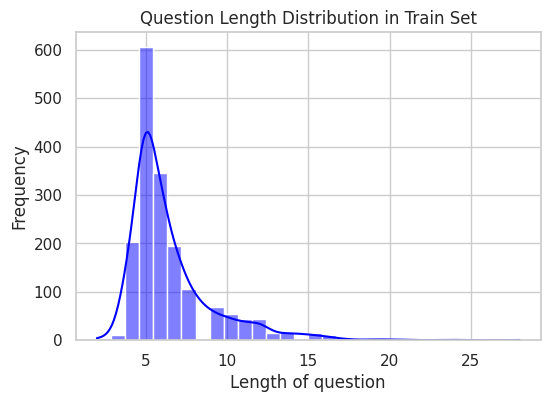

In [ ]:
# Функция для вычисления длины текста и вопроса
def plot_text_length_distribution(df, column, title, filename):
    df['text_length'] = df[column].apply(lambda x: len(x.split()))  # Длина в словах
    plt.figure(figsize=(6, 4))
    sns.histplot(df['text_length'], kde=True, color="blue", bins=30)
    plt.title(title)
    plt.xlabel(f"Length of {column}")
    plt.ylabel("Frequency")
    plt.savefig(filename)
    plt.show()

plot_text_length_distribution(train_df, 'passage', "Text Length Distribution in Train Set", 'text_distribution.png')
plot_text_length_distribution(train_df, 'question', "Question Length Distribution in Train Set", 'question_distribution.png')

кодируем лейблы

In [ ]:
train_df['label'] = train_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)

In [ ]:
train_labels = train_df['label'].tolist()
val_labels = val_df['label'].tolist()

In [ ]:
type(train_df['label'].tolist()[0])

int

In [ ]:
train_df.head()

,question,passage,label,idx
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True,0
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True,1
2,Был ли джиган в black star?,Вместе с этим треком они выступили на церемони...,True,2
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010...",True,3
4,Был ли автомат калашникова в вов?,Отметив некоторые недостатки и в целом удачную...,False,4


проверяем данные на наличие nan

In [ ]:
print(train_df.isna().any(),
      val_df.isna().any(),
      test_df.isna().any())

question    False
passage     False
label       False
idx         False
dtype: bool question    False
passage     False
label       False
idx         False
dtype: bool question    False
passage     False
idx         False
dtype: bool


лемматизируем pymorphy, удаляем стопслова и знаки препинания

In [ ]:
questions_train = train_df['question'].tolist()
answers_train = train_df['passage'].tolist()

questions_val = val_df['question'].tolist()
answers_val = val_df['passage'].tolist()

questions_test = test_df['question'].tolist()
answers_test = test_df['passage'].tolist()

In [ ]:
preprocessed_train_questions = train_df['question'].progress_apply(preprocessing, morph=morph)
preprocessed_train_passages = train_df['passage'].progress_apply(preprocessing, morph=morph)

preprocessed_val_questions = val_df['question'].progress_apply(preprocessing, morph=morph)
preprocessed_val_passages = val_df['passage'].progress_apply(preprocessing, morph=morph)

preprocessed_test_questions = test_df['question'].progress_apply(preprocessing, morph=morph)
preprocessed_test_passages = test_df['passage'].progress_apply(preprocessing, morph=morph)

100%|██████████| 805/805 [00:26<00:00, 30.11it/s]


In [ ]:
def write_lemmas_to_df(preprocessed_q, preprocessed_p, df_name, column_text, column_lemmas):
    preprocessed_text = [preprocessed_p[i][0] + preprocessed_q[i][0] for i in range(len(preprocessed_q))]
    lemmas = [preprocessed_p[i][1] + preprocessed_q[i][1] for i in range(len(preprocessed_q))]
    df_name[column_text] = preprocessed_text
    df_name[column_lemmas] = lemmas

In [ ]:
column_text = 'lemmatized_text'
column_lemmas = 'lemmas'
write_lemmas_to_df(preprocessed_train_questions, preprocessed_train_passages,
                   train_df, column_text, column_lemmas)
write_lemmas_to_df(preprocessed_val_questions, preprocessed_val_passages,
                   val_df, column_text, column_lemmas)
write_lemmas_to_df(preprocessed_test_questions, preprocessed_test_passages,
                   test_df, column_text, column_lemmas)

сохраняем с изменёнными лейблами и лемматизацией в .pkl

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/dataframes.pkl', 'wb') as f:
    pickle.dump((train_df, val_df, test_df), f)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/dataframes.pkl', 'rb') as f:
    train_df, val_df, test_df = pickle.load(f)

# **Rule-based подход**

В рамках rule-based подхода были определены условия классификации, опирающиеся на сравнение грамматических основ вопроса и текста.

In [ ]:
import pdfplumber
import re
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

tqdm.pandas()

In [ ]:
pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 39.7 MB/s eta 0:00:00


В качестве источника синонимов использовался ["Словарь синонимов и антонимов современного русского языка" (Автор: Гаврилова А.С.).](https://nn.msrabota.ru/content/book_docs/a.s.gavrilova-slovar_sinonimov_i_antonimov_.pdf). В этом файле страницы разделены на два столбца, что требовало особого подхода при парсинге данных.

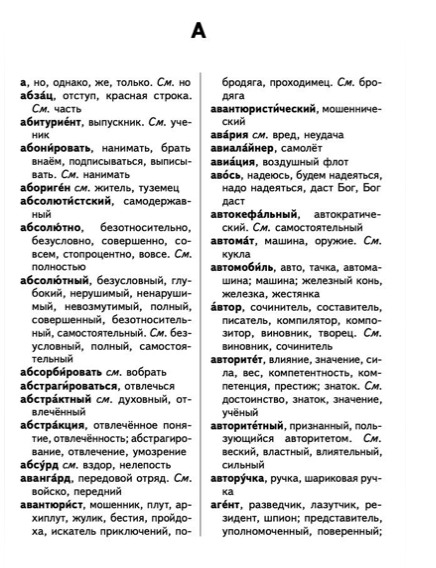

In [ ]:
def extract_text_from_columns(pdf_path, output_file, pages):
    """
    Извлекает текст из PDF с колонками.

    :param pdf_path: Путь к PDF-файлу
    :param output_file: Путь к выходному текстовому файлу
    :param pages: Список номеров страниц
    """
    with pdfplumber.open(pdf_path) as pdf, open(output_file, 'w', encoding='utf-8') as out_file:
        for page_number in tqdm(pages, desc="Обработка страниц"):
            if page_number > len(pdf.pages) or page_number < 1:
                print(f"Предупреждение: страница {page_number} отсутствует в файле.")
                continue

            page = pdf.pages[page_number - 1]

            words = page.extract_words()

            # Разделение колонок
            left_column = []
            right_column = []
            midpoint = page.width / 2  # Считаем, что страницы делятся пополам

            for word in words:
                # Сортируем слова по их координате x
                if word['x0'] < midpoint:
                    left_column.append(word['text'])
                else:
                    right_column.append(word['text'])

            # Собираем текст построчно
            left_text = ' '.join(left_column)
            right_text = ' '.join(right_column)

            out_file.write(left_text + '\n' + right_text + '\n\n')

pdf_file = "7.pdf"
output_text_file = "output_columns.txt"
specific_pages = [i for i in range(7, 428)]

extract_text_from_columns(pdf_file, output_text_file, specific_pages)

Обработка страниц: 100%|██████████| 421/421 [01:02<00:00,  6.73it/s]


In [ ]:
content = ""
with open('output_columns.txt', 'r', encoding='utf-8') as file:
    for line in file:
        content += line.strip() + " "
synonyms_text = content.strip()

In [ ]:
synonyms_text = synonyms_text.replace('.См.', ' ')
synonyms_text = synonyms_text.replace('См.', ' ')
synonyms_text = synonyms_text.replace(' см. ', ' ')
synonyms_text = synonyms_text.replace(' см', ' ')
synonyms_text = synonyms_text.replace('см ', ' ')
synonyms_text = synonyms_text.replace('см.', ' ')
synonyms_text = synonyms_text.replace('CЛОВАРЬ СИНОНИМОВ ', ' ')
synonyms_text = synonyms_text.replace('(книжн.)', ' ')
synonyms_text = synonyms_text.replace('(прост.)', ' ')
synonyms_text = synonyms_text.replace('-', ' ')
synonyms_text = synonyms_text.replace('- ', ' ')
synonyms_text = synonyms_text.replace('- ', ' ')
synonyms_text = synonyms_text.replace(';', ' ')
synonyms_text = synonyms_text.replace('.', ',')
synonyms_text = synonyms_text.replace(' ', ',')
synonyms_text = ''.join([char for char in synonyms_text if not char.isdigit()])

In [ ]:
from tqdm import tqdm

def create_dictionary_without_regex(text):
    dictionary = {}
    lines = text.split(',')

    for i, word in tqdm(enumerate(lines)):
        if '´' in word:
            key = word.strip(',')
            values = []
            j = i + 1
            while j < len(lines) and '´' not in lines[j] and 'см.' not in lines[j]:
                values.append(lines[j].strip(','))
                j += 1
            dictionary[key] = values

    return dictionary

synonyms_dict = create_dictionary_without_regex(synonyms_text.lower())

152304it [00:00, 1141738.03it/s]


In [ ]:
def clean_dictionary(dictionary):
    cleaned_dict = {}
    for key, values in dictionary.items():
        cleaned_key = key.replace('´', '')
        cleaned_values = [value for value in values if value.strip() != '']
        cleaned_dict[cleaned_key] = cleaned_values
    return cleaned_dict

cleaned_dict = clean_dictionary(synonyms_dict)

In [ ]:
import spacy
try:
    nlp = spacy.load("ru_core_news_sm")
except:
    import os
    os.system("python -m spacy download ru_core_news_sm")
    nlp = spacy.load("ru_core_news_sm")

Rule-based классификация опирается на сравнение грамматических основ вопроса и текста.

1. Если подлежащее и сказуемое двух текстов совпадают, присваиваем лейбл True

2. Если подлежащее и сказуемое двух текстов совпадают, но перед одним из сказуемых находится частица ‘не’, присваиваем лейбл False

3. Если грамматические основы лексически не совпадают, то определяем, являются ли они синонимами.


In [ ]:
def extract_subject_predicate(doc):
    """Извлекает подлежащее и сказуемое из текста"""
    subject = None
    predicate = None
    subj_idx = None
    pred_idx = None

    for token in doc:
        if token.dep_ in {"nsubj", "nsubj:pass"}:
            subject = token

        if token.pos_ == "VERB":
            predicate = token

        if subject and predicate:
            break

    return subject, predicate,

def rule_based_check(text, question):

    doc_text = nlp(text.lower())
    doc_question = nlp(question.lower())

    subj_text, pred_text = extract_subject_predicate(doc_text)
    subj_question, pred_question = extract_subject_predicate(doc_question)

    result = False

    if pred_text and pred_question:
        negation_text = False
        for child in pred_text.children:
            if child.text.lower() == "не":
                negation_text = True
                break

        negation_question = False
        for child in pred_question.children:
            if child.text.lower() == "не":
                negation_question = True
                break

        if negation_text != negation_question:
            return False

    subj_match = None
    pred_match = None

    if subj_text and subj_question:
        if subj_text.lemma_ == subj_question.lemma_:
            subj_match = True
        else:
            subj_match = False

    if pred_text and pred_question:
        if pred_text.lemma_ == pred_question.lemma_:
            pred_match = True
        else:
            pred_match = False

            if pred_text.lemma_ in cleaned_dict:
                if isinstance(cleaned_dict[pred_text.lemma_], str):
                    if pred_question.lemma_ in cleaned_dict[pred_text.lemma_]:
                        pred_match = True
                    else:
                        pred_match = False
                else:
                    pred_match = False

            if pred_question.lemma_ in cleaned_dict:
                if isinstance(cleaned_dict[pred_question.lemma_], str):
                    if pred_text.lemma_ in cleaned_dict[pred_question.lemma_]:
                        pred_match = True
                    else:
                        pred_match = False
                else:
                    pred_match = False

    if subj_match != False and pred_match != False:
        return True

    return result

In [ ]:
train_df['result'] = train_df.progress_apply(lambda row: rule_based_check(row['passage'], row['question']), axis=1)

100%|██████████| 1749/1749 [02:44<00:00, 10.62it/s]


In [ ]:
train_df

,question,passage,label,idx,result
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True,0,False
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True,1,False
2,Был ли джиган в black star?,Вместе с этим треком они выступили на церемони...,True,2,True
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010...",True,3,True
4,Был ли автомат калашникова в вов?,Отметив некоторые недостатки и в целом удачную...,False,4,False
...,...,...,...,...,...
1744,Разрешен ли такой вид ловли акул в настоящее в...,Для человека они потенциально полезны в медици...,True,1745,False
1745,Закреплено ли Гражданство в Конституции,Гражданство является одним из институтов конст...,True,1746,False
1746,"Существуют ли примеры, когда не совсем достато...",В философии под эффективностью понимается спос...,True,1747,False
1747,Решен ли вопрос о подлинности Диалога Тацита?,В XIX веке Диалог считали первым произведением...,False,1748,False


In [ ]:
accuracy = accuracy_score(train_df['label'], train_df['result'])
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(train_df['label'], train_df['result'], average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

Accuracy: 0.4460
F1-score (weighted): 0.3709


## Замена словаря на векторную модель

В коде ниже мы решили заменить словарь синонимов на векторую модель, которая бы определяла близость слов. Мы предположили, что это сработает лучше, поскольку словарь синонимов может быть менее лексически наполнен и не включать в себя исчрепывающий список синонимов. Векторная модель была взята из ресурса http://vectors.nlpl.eu/repository/, модель номер 180. В качестве метрики близости слов было выбрано косинусное расстояние.

In [ ]:
import spacy
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from scipy.spatial.distance import cosine

In [ ]:
vector_model = KeyedVectors.load_word2vec_format('180/model.txt')

In [ ]:
def get_sentence_vector(sentence, model):
    """Получаем вектор предложения путём усреднения векторов слов."""
    word_vectors = []

    for word in sentence:
        if word in model:
            word_vectors.append(model[word])

    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def extract_subject_predicate(doc, model):
    """Извлекает подлежащее и сказуемое из текста, используя векторные представления."""
    subject = None
    predicate = None
    subj_idx = None
    pred_idx = None

    for token in doc:
        if token.dep_ in {"nsubj", "nsubj:pass"}:
            subject = token
        if token.pos_ == "VERB":
            predicate = token

        if subject and predicate:
            break

    if subject and predicate:
        subj_vector = get_sentence_vector([subject.text], model)
        pred_vector = get_sentence_vector([predicate.text], model)

        return subj_vector, pred_vector

    return None, None

def rule_based_check(text, question, threshold=0.8):
    """Проверка на схожесть предложений (текста и вопроса) на основе векторных представлений."""
    doc_text = nlp(text.lower())
    doc_question = nlp(question.lower())

    subj_text_vector, pred_text_vector = extract_subject_predicate(doc_text, vector_model)
    subj_question_vector, pred_question_vector = extract_subject_predicate(doc_question, vector_model)

    result = False

    if subj_text_vector is not None and subj_question_vector is not None:
        subj_similarity = 1 - cosine(subj_text_vector, subj_question_vector)
        if subj_similarity >= threshold:
            subj_match = True
        else:
            subj_match = False
    else:
        subj_match = False

    if pred_text_vector is not None and pred_question_vector is not None:
        pred_similarity = 1 - cosine(pred_text_vector, pred_question_vector)
        if pred_similarity >= threshold:
            pred_match = True
        else:
            pred_match = False
    else:
        pred_match = False

    if subj_match and pred_match:
        return True

    return result

In [ ]:
train_df['result'] = train_df.progress_apply(lambda row: rule_based_check(row['passage'], row['question']), axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(train_df['label'], train_df['result'])
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(train_df['label'], train_df['result'], average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

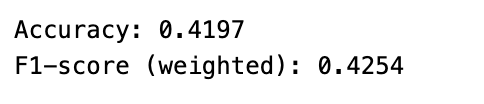

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(train_df['label'], train_df['result']))

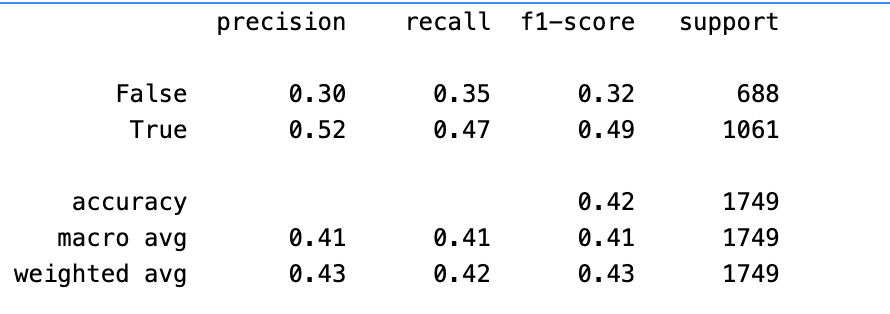

(код запускался в другой тетрадке, поэтому результат вставляю в виде картинок)

Представление с использованием векторной модели улучшилось.

# **ML 1**
embedding models + LogReg

### rubert-tiny

In [ ]:
model = SentenceTransformer('cointegrated/rubert-tiny2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
train_embeddings = model.encode([answers_train[i] + ' ' + questions_train[i] for i in range(len(answers_train))])

val_embeddings = model.encode([answers_val[i] + ' ' + questions_val[i] for i in range(len(answers_val))])

test_embeddings = model.encode([answers_test[i] + ' ' + questions_test[i] for i in range(len(answers_test))])

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/train_rubert_embeddings.pkl', 'wb') as f:
    pickle.dump(train_embeddings, f)

with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/val_rubert_embeddings.pkl', 'wb') as f:
    pickle.dump(val_embeddings, f)

with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/test_rubert_embeddings.pkl', 'wb') as f:
    pickle.dump(test_embeddings, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/train_rubert_embeddings.pkl', 'rb') as f:
    train_embeddings = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/val_rubert_embeddings.pkl', 'rb') as f:
    val_embeddings = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/test_rubert_embeddings.pkl', 'rb') as f:
    test_embeddings = pickle.load(f)

In [ ]:
classifier = LogisticRegression(max_iter=1000)

In [ ]:
# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['liblinear', 'saga']
}

In [ ]:
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(train_embeddings, train_df['label'])

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'solver': ['liblinear', 'saga']})

In [ ]:
print("Лучшие гиперпараметры:", grid_search.best_params_)

Лучшие гиперпараметры: {'C': 100.0, 'solver': 'liblinear'}


In [ ]:
val_predictions_bert = grid_search.predict(val_embeddings)

print(classification_report(val_df['label'], val_predictions_bert))

              precision    recall  f1-score   support

           0       0.65      0.31      0.42       409
           1       0.55      0.83      0.66       412

    accuracy                           0.57       821
   macro avg       0.60      0.57      0.54       821
weighted avg       0.60      0.57      0.54       821



In [ ]:
f1_score(val_df['label'], val_predictions_bert, average='weighted')

0.5421141130510835

### e5

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/dataframes.pkl', 'rb') as f:
    train_df, val_df, test_df = pickle.load(f)

In [ ]:
questions_train = train_df['question'].tolist()
answers_train = train_df['passage'].tolist()

questions_val = val_df['question'].tolist()
answers_val = val_df['passage'].tolist()

questions_test = test_df['question'].tolist()
answers_test = test_df['passage'].tolist()

In [ ]:
def get_emb_e5(sentences, model):
    sentences_e5 = [''] * len(sentences)
    for i in range(len(sentences)):
        sentences_e5[i] = "query: " + sentences[i]
    sentences_embeddings = model.encode(sentences_e5, normalize_embeddings=True)
    return sentences_embeddings

In [ ]:
model_e5 = SentenceTransformer('intfloat/multilingual-e5-large')

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

In [ ]:
train_embeddings_e5 = get_emb_e5([answers_train[i] + ' ' + questions_train[i] for i in range(len(answers_train))], model_e5)

val_embeddings_e5 = get_emb_e5([answers_val[i] + ' ' + questions_val[i] for i in range(len(answers_val))], model_e5)

test_embeddings_e5 = get_emb_e5([answers_test[i] + ' ' + questions_test[i] for i in range(len(answers_test))], model_e5)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/train_e5_embeddings.pkl', 'wb') as f:
    pickle.dump(train_embeddings_e5, f)

with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/val_e5_embeddings.pkl', 'wb') as f:
    pickle.dump(val_embeddings_e5, f)

with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/test_e5_embeddings.pkl', 'wb') as f:
    pickle.dump(test_embeddings_e5, f)

In [ ]:
classifier = LogisticRegression(max_iter=1000)

In [ ]:
# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['liblinear', 'saga']
}

In [ ]:
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(train_embeddings_e5, train_df['label'])

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'solver': ['liblinear', 'saga']})

In [ ]:
print("Лучшие гиперпараметры:", grid_search.best_params_)

Лучшие гиперпараметры: {'C': 10.0, 'solver': 'liblinear'}


In [ ]:
val_predictions = grid_search.predict(val_embeddings_e5)

print(classification_report(val_df['label'], val_predictions))

              precision    recall  f1-score   support

           0       0.70      0.24      0.36       409
           1       0.54      0.90      0.68       412

    accuracy                           0.57       821
   macro avg       0.62      0.57      0.52       821
weighted avg       0.62      0.57      0.52       821



In [ ]:
f1_score(val_df['label'], val_predictions, average='weighted')

0.519408208519049

### gigachat-embedding

In [ ]:
!pip uninstall torch
!pip uninstall transformers
!pip uninstall sentence-transformers

In [ ]:
!pip install torch -q
!pip install transformers -q
!pip install sentence-transformers -q

In [ ]:
!pip install torch==2.2.0, transformers==4.42.4, sentence-transformers==2.7.0 -q

In [ ]:
import transformers

In [ ]:
import pickle

In [ ]:
import os
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/dataframes.pkl', 'rb') as f:
    train_df, val_df, test_df = pickle.load(f)

In [ ]:
!pip install transformers==4.43.4

In [ ]:
!pip install datasets -q

In [ ]:
# load model with tokenizer
model = AutoModel.from_pretrained('ai-sage/Giga-Embeddings-instruct', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/47.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.02M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model.to(device)

GigarEmbedModel(
  (latent_attention_model): LatentAttentionModel(
    (cross_attend_blocks): ModuleList(
      (0-1): 2 x PreNorm()
    )
  )
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=2)
    (layers): ModuleList(
      (0-26): 27 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (in

In [ ]:
# Each query needs to be accompanied by an corresponding instruction describing the task.
task_name_to_instruct = {"example": "Given a question, retrieve passages that answer the question",}

query_prefix = task_name_to_instruct["example"] + "\nquestion: "

# No instruction needed for retrieval passages
passage_prefix = ""

In [ ]:
questions_train = train_df['question'].tolist()
answers_train = train_df['passage'].tolist()

questions_val = val_df['question'].tolist()
answers_val = val_df['passage'].tolist()

questions_test = test_df['question'].tolist()
answers_test = test_df['passage'].tolist()

In [ ]:
q_embeddings_train = []
for q in questions_train:
    q_emb = model.encode([q], instruction=query_prefix)
    q_embeddings_train.append(q_emb[0].cpu().detach().numpy())

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [ ]:
p_embeddings_train = []
for p in answers_train:
    p_emb = model.encode([p], instruction=passage_prefix)
    p_embeddings_train.append(p_emb[0].cpu().detach().numpy())

In [ ]:
q_embeddings_val = []
for q in questions_val:
    q_emb = model.encode([q], instruction=query_prefix)
    q_embeddings_val.append(q_emb[0].cpu().detach().numpy())

In [ ]:
p_embeddings_val = []
for p in answers_val:
    p_emb = model.encode([p], instruction=passage_prefix)
    p_embeddings_val.append(p_emb[0].cpu().detach().numpy())

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/giga_embeddings.pkl', 'wb') as f:
    pickle.dump((q_embeddings_train, p_embeddings_train, q_embeddings_val, p_embeddings_val), f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/giga_embeddings.pkl', 'rb') as f:
    q_embeddings_train, p_embeddings_train, q_embeddings_val, p_embeddings_val = pickle.load(f)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier = LogisticRegression(max_iter=1000, random_state=0)

In [ ]:
# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['liblinear', 'saga']
}

In [ ]:
train_embeddings = [(p_embeddings_train[i] + q_embeddings_train[i])/2 for i in range(len(p_embeddings_train))]

In [ ]:
val_embeddings = [(p_embeddings_val[i] + q_embeddings_val[i])/2 for i in range(len(p_embeddings_val))]

In [ ]:
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(train_embeddings, train_df['label'])

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=0),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'solver': ['liblinear', 'saga']})

In [ ]:
print("Лучшие гиперпараметры:", grid_search.best_params_)

Лучшие гиперпараметры: {'C': 1.0, 'solver': 'liblinear'}


In [ ]:
val_predictions_giga = grid_search.predict(val_embeddings)

print(classification_report(val_df['label'], val_predictions_giga))

              precision    recall  f1-score   support

           0       0.85      0.18      0.29       409
           1       0.54      0.97      0.70       412

    accuracy                           0.57       821
   macro avg       0.69      0.57      0.49       821
weighted avg       0.69      0.57      0.49       821



In [ ]:
f1_score(val_df['label'], val_predictions_giga, average='weighted')

0.4940474006908847

# **ML 2**

In [ ]:
X = train_df['question'] + ' ' + train_df['passage']
y = train_df['idx']

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss, logits = outputs[:2]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=2)

def get_label(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    max_length = 512
    if len(inputs) > max_length:
        inputs = inputs[:512]

    labels = torch.tensor([1]).unsqueeze(0)

    outputs = model(**inputs, labels=labels)
    loss, logits = outputs[:2]
    softmax = torch.nn.Softmax(dim=1)
    probs = softmax(logits)

    predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tqdm import tqdm

tqdm.pandas()

In [ ]:
train_df_sample = train_df.sample(n=500, random_state=42)

In [ ]:
train_df_sample['rubert_label'] = train_df_sample.progress_apply(
    lambda row: get_label(row['passage'] + ' ' + row['question']), axis=1)

100%|██████████| 500/500 [06:20<00:00,  1.31it/s]


In [ ]:
train_df_sample['label'] = train_df_sample['label'].astype(int)

In [ ]:
train_df_sample

,question,passage,label,idx,rubert_label
660,Был ли титаник на самом деле?,"Лайнер мог брать на борт до 2439 пассажиров, н...",True,660,1
1353,Могут ли белки быть заменены другими пищевыми ...,Для правильного построения питания недостаточн...,False,1354,1
861,Был ли леонов в открытом космосе?,Восход-2 — советский пилотируемый космический ...,True,861,1
111,Вреден ли вейп с никотином?,"Никоти́н — алкалоид пиридинового ряда, содержа...",True,111,1
332,А были ли танки у немцев 22 июня 1941 года?,Сражение в районе Дубно — Луцк — Броды — одно...,True,332,1
...,...,...,...,...,...
363,Есть ли в моркови крахмал?,"Плод — округло-эллиптический, плоскосжатый, же...",True,363,1
819,Был ли у люцифера сын?,"Нечисть ведёт себя слишком агрессивно, Джон чу...",True,819,1
354,Были ли у ленина еврейские корни?,Однако тогда же ЦК РКП распорядился держать ин...,True,354,1
427,Был ли сократ?,Сократ показывает своё незнание в данном аспек...,True,427,1


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(train_df_sample['rubert_label'], train_df_sample['label'])
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(train_df_sample['rubert_label'], train_df_sample['label'], average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

Accuracy: 0.6020
F1-score (weighted): 0.7212


Здесь мы посчитали базовую точность ruBert  на наших данных как классификатора.

## Добавление слоя внимания на скрытом представлении

BERT уже использует механизм внимания на уровне самих трансформеров, но можно добавить дополнительные слои внимания, чтобы модель могла еще точнее выделять важные части текста.

Также был добавлен Dropout для регуляризации. Dropout помогает избежать переобучения, обнуляя случайные нейроны в ходе обучения.

In [ ]:
train_df_sample = train_df.sample(n=500, random_state=42)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch import nn

class BertWithAttentionLayer(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_rate=0.3):
        super(BertWithAttentionLayer, self).__init__()

        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

        self.attention = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=8)

        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)

        hidden_states = outputs.hidden_states[-1]

        hidden_states = hidden_states.permute(1, 0, 2)
        attn_output, _ = self.attention(hidden_states, hidden_states, hidden_states)

        attn_output = attn_output.mean(dim=0)


        x = self.dropout(attn_output)
        logits = self.output(x)

        return logits

def get_label_from_logits(logits):
    """
    Функция для получения лейбла (класса) из логитов.
    """
    predicted_label = torch.argmax(logits, dim=-1).item()
    return predicted_label

def get_prediction(text, model, tokenizer):
    """
    Функция для получения предсказания (класса) для входного текста.
    """

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)


    with torch.no_grad():
        outputs = model(**inputs)


    predicted_label = get_label_from_logits(outputs)

    return predicted_label


In [ ]:
model_name ='DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertWithAttentionLayer(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_df_sample['rubert_label'] = train_df_sample.progress_apply(
    lambda row: get_prediction(row['passage'] + ' ' + row['question'], model, tokenizer), axis=1)

100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


In [ ]:
train_df_sample['rubert_label_prep'] = train_df_sample['rubert_label'].astype(int)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(train_df_sample['rubert_label_prep'], train_df_sample['label'])
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(train_df_sample['rubert_label_prep'], train_df_sample['label'], average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

Accuracy: 0.5880
F1-score (weighted): 0.6320


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(train_df_sample['label'], train_df_sample['rubert_label_prep']))

              precision    recall  f1-score   support

       False       0.43      0.21      0.28       194
        True       0.62      0.83      0.71       306

    accuracy                           0.59       500
   macro avg       0.53      0.52      0.50       500
weighted avg       0.55      0.59      0.54       500



## Добавление дополнительных слоев

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from torch import nn

class BertWithAdditionalLayers(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_rate=0.3):
        super(BertWithAdditionalLayers, self).__init__()

        self.bert = BertModel.from_pretrained(model_name)

        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(self.bert.config.hidden_size, 512)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(512, 128)
        self.output = nn.Linear(128, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        cls_embedding = outputs.last_hidden_state[:, 0, :]

        x = self.dropout(cls_embedding)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.dropout(x)

        logits = self.output(x)

        return logits

def get_label_from_logits(logits):
    """
    Функция для получения лейбла (класса) из логитов.
    """
    predicted_label = torch.argmax(logits, dim=-1).item()
    return predicted_label

def get_prediction(text, model, tokenizer):
    """
    Функция для получения предсказания (класса) для входного текста.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        logits = model(**inputs)

    predicted_label = get_label_from_logits(logits)

    return predicted_label

In [ ]:
model_name ='DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertWithAdditionalLayers(model_name, num_labels=2)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_df_sample['rubert_label_3'] = train_df_sample.progress_apply(
    lambda row: get_prediction(row['passage'] + ' ' + row['question'], model, tokenizer), axis=1)

100%|██████████| 500/500 [03:50<00:00,  2.17it/s]


In [ ]:
train_df_sample['rubert_label_3_prep'] = train_df_sample['rubert_label_3'].astype(int)

In [ ]:
accuracy = accuracy_score(train_df_sample['rubert_label_3_prep'], train_df_sample['label'])
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(train_df_sample['rubert_label_3_prep'], train_df_sample['label'], average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

Accuracy: 0.6140
F1-score (weighted): 0.6821


In [ ]:
print(classification_report(train_df_sample['label'], train_df_sample['rubert_label_3_prep']))

              precision    recall  f1-score   support

       False       0.51      0.15      0.24       194
        True       0.63      0.91      0.74       306

    accuracy                           0.61       500
   macro avg       0.57      0.53      0.49       500
weighted avg       0.58      0.61      0.55       500



# **DL**
LSTM

### с лемматизацией

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/project_nlp/dataframes.pkl', 'rb') as f:
    train_df, val_df, test_df = pickle.load(f)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
X_train = train_df['lemmatized_text']
y_train = train_df['label']
X_val = val_df['lemmatized_text']
y_val = val_df['label']

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

max_length = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True


In [ ]:
with tf.device('/GPU:0'):
    model.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_data=(X_val_pad, y_val))

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.5379 - loss: 1.0066 - val_accuracy: 0.5018 - val_loss: 0.7303
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5911 - loss: 0.6690 - val_accuracy: 0.5201 - val_loss: 0.6870
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7338 - loss: 0.6017 - val_accuracy: 0.5445 - val_loss: 0.7157
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7957 - loss: 0.5021 - val_accuracy: 0.5737 - val_loss: 1.0094
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8462 - loss: 0.3447 - val_accuracy: 0.5956 - val_loss: 0.8336


In [ ]:
loss, accuracy = model.evaluate(X_val_pad, y_val)
print(f"Accuracy: {accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5897 - loss: 0.8552
Accuracy: 0.5956150889396667


In [ ]:
pred = model.predict(X_val_pad)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [ ]:
len(pred)

821

In [ ]:
y_pred = np.argmax(pred, axis=1)

In [ ]:
f1_keras = f1_score(y_val, y_pred, average='weighted')

In [ ]:
print(f'F1_score: {f1_keras}')

F1_score: 0.5743345487101598


In [ ]:
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.5956151035322778
              precision    recall  f1-score   support

           0       0.67      0.37      0.48       409
           1       0.57      0.82      0.67       412

    accuracy                           0.60       821
   macro avg       0.62      0.59      0.57       821
weighted avg       0.62      0.60      0.57       821



c 2мя LSTM слоями

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout, BatchNormalization

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(SpatialDropout1D(0.2))

model.add(LSTM(128, return_sequences=True))  # Увеличиваем количество нейронов и добавляем return_sequences
model.add(Dropout(0.2))  # Dropout для предотвращения переобучения

model.add(LSTM(64))  # Второй LSTM слой с меньшим количеством нейронов
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))  # Полносвязный слой с ReLU активацией
model.add(BatchNormalization())  # Нормализация

model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())

with tf.device('/GPU:0'):
    model.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_data=(X_val_pad, y_val))

GPU Available: True
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.4302 - loss: 1.0688 - val_accuracy: 0.5030 - val_loss: 1.0348
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7913 - loss: 0.6792 - val_accuracy: 0.5067 - val_loss: 0.9941
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9413 - loss: 0.2719 - val_accuracy: 0.5408 - val_loss: 0.9648
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9761 - loss: 0.1027 - val_accuracy: 0.5432 - val_loss: 0.9674
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9850 - loss: 0.0738 - val_accuracy: 0.5445 - val_loss: 0.9452


In [ ]:
loss, accuracy = model.evaluate(X_val_pad, y_val)
print(f"Accuracy: {accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5052 - loss: 0.9705
Accuracy: 0.5444579720497131


In [ ]:
pred = model.predict(X_val_pad)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm.auto import tqdm
from tqdm import tqdm
tqdm.pandas()

In [ ]:
y_pred = np.argmax(pred, axis=1)
f1_keras = f1_score(y_val, y_pred, average='weighted')

print(f'F1_score: {f1_keras}')
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

F1_score: 0.4420208852073014
Accuracy: 0.5444579780755177
              precision    recall  f1-score   support

           0       0.80      0.11      0.20       409
           1       0.52      0.97      0.68       412

    accuracy                           0.54       821
   macro avg       0.66      0.54      0.44       821
weighted avg       0.66      0.54      0.44       821



### без лемматизации

In [ ]:
X_train_p = train_df['passage']
X_train_q = train_df['question']
y_train = train_df['label']
X_val_p = val_df['passage']
X_val_q = val_df['question']
y_val = val_df['label']

In [ ]:
X_train = []
for i in range(len(X_train_p)):
    X_train.append(X_train_p[i] + " " + X_train_q[i])

In [ ]:
X_val = []
for i in range(len(X_val_p)):
    X_val.append(X_val_p[i] + " " + X_val_q[i])

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [ ]:
max_length = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())

with tf.device('/GPU:0'):
    model.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_data=(X_val_pad, y_val))

GPU Available: True
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5142 - loss: 1.0192 - val_accuracy: 0.5018 - val_loss: 0.7711
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5773 - loss: 0.6898 - val_accuracy: 0.5018 - val_loss: 0.7679
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6405 - loss: 0.6394 - val_accuracy: 0.5091 - val_loss: 0.6940
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7111 - loss: 0.5633 - val_accuracy: 0.5932 - val_loss: 0.7035
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8197 - loss: 0.4098 - val_accuracy: 0.6175 - val_loss: 0.7704


In [ ]:
loss, accuracy = model.evaluate(X_val_pad, y_val)
print(f"Accuracy: {accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6001 - loss: 0.7967
Accuracy: 0.6175395846366882


In [ ]:
pred = model.predict(X_val_pad)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
len(pred)

821

In [ ]:
y_pred = np.argmax(pred, axis=1)

In [ ]:
f1_keras = f1_score(y_val, y_pred, average='weighted')

print(f'F1_score: {f1_keras}')

F1_score: 0.577884910060987


In [ ]:

print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.6175395858708892
              precision    recall  f1-score   support

           0       0.80      0.31      0.45       409
           1       0.57      0.92      0.71       412

    accuracy                           0.62       821
   macro avg       0.69      0.62      0.58       821
weighted avg       0.69      0.62      0.58       821



In [ ]:
model = Sequential()

model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(SpatialDropout1D(0.2))

model.add(LSTM(128, return_sequences=True))  # Увеличиваем количество нейронов и добавляем return_sequences

model.add(LSTM(64))  # Второй LSTM слой с меньшим количеством нейронов

model.add(Dense(64, activation='relu'))  # Полносвязный слой с ReLU активацией
model.add(BatchNormalization())  # Нормализация

model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())

with tf.device('/GPU:0'):
    model.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_data=(X_val_pad, y_val))

GPU Available: True
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.4917 - loss: 1.0560 - val_accuracy: 0.5018 - val_loss: 1.0497
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8114 - loss: 0.6372 - val_accuracy: 0.5030 - val_loss: 1.0039
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9394 - loss: 0.2737 - val_accuracy: 0.5116 - val_loss: 1.0290
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9788 - loss: 0.0888 - val_accuracy: 0.5225 - val_loss: 1.0343
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9838 - loss: 0.0555 - val_accuracy: 0.5323 - val_loss: 0.9917


In [ ]:
loss, accuracy = model.evaluate(X_val_pad, y_val)
print(f"Accuracy: {accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4855 - loss: 1.0321
Accuracy: 0.5322777032852173


In [ ]:
pred = model.predict(X_val_pad)
y_pred = np.argmax(pred, axis=1)
f1_keras = f1_score(y_val, y_pred, average='weighted')

print(f'F1_score: {f1_keras}')
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
F1_score: 0.41800567273791817
Accuracy: 0.5322777101096224
              precision    recall  f1-score   support

           0       0.77      0.09      0.16       409
           1       0.52      0.97      0.68       412

    accuracy                           0.53       821
   macro avg       0.64      0.53      0.42       821
weighted avg       0.64      0.53      0.42       821



# **Instruct-Модель**

In [ ]:
pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.1 MB/s eta 0:00:00


In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

MODEL_NAME = "IlyaGusev/saiga_mistral_7b"
DEFAULT_MESSAGE_TEMPLATE = "<s>{role}\n{content}</s>"
DEFAULT_RESPONSE_TEMPLATE = "<s>bot\n"
DEFAULT_SYSTEM_PROMPT = "Ты — Сайга, русскоязычный автоматический ассистент. Ты разговариваешь с людьми и помогаешь им."

class Conversation:
    def __init__(
        self,
        message_template=DEFAULT_MESSAGE_TEMPLATE,
        system_prompt=DEFAULT_SYSTEM_PROMPT,
        response_template=DEFAULT_RESPONSE_TEMPLATE
    ):
        self.message_template = message_template
        self.response_template = response_template
        self.messages = [{
            "role": "system",
            "content": system_prompt
        }]

    def add_user_message(self, message):
        self.messages.append({
            "role": "user",
            "content": message
        })

    def add_bot_message(self, message):
        self.messages.append({
            "role": "bot",
            "content": message
        })

    def get_prompt(self, tokenizer):
        final_text = ""
        for message in self.messages:
            message_text = self.message_template.format(**message)
            final_text += message_text
        final_text += DEFAULT_RESPONSE_TEMPLATE
        return final_text.strip()


def generate(model, tokenizer, prompt, generation_config):
    data = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    data = {k: v.to(model.device) for k, v in data.items()}
    output_ids = model.generate(
        **data,
        generation_config=generation_config
    )[0]
    output_ids = output_ids[len(data["input_ids"][0]):]
    output = tokenizer.decode(output_ids, skip_special_tokens=True)
    return output.strip()

config = PeftConfig.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto"
)
model = PeftModel.from_pretrained(
    model,
    MODEL_NAME,
    torch_dtype=torch.float16
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
print(generation_config)

inputs = ["Почему трава зеленая?", "Сочини длинный рассказ, обязательно упоминая следующие объекты. Дано: Таня, мяч"]
for inp in inputs:
    conversation = Conversation()
    conversation.add_user_message(inp)
    prompt = conversation.get_prompt(tokenizer)

    output = generate(model, tokenizer, prompt, generation_config)
    print(inp)
    print(output)
    print()
    print("==============================")
    print()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/54.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

GenerationConfig {
  "bos_token_id": 1,
  "do_sample": true,
  "eos_token_id": 2,
  "max_new_tokens": 1536,
  "no_repeat_ngram_size": 15,
  "pad_token_id": 0,
  "repetition_penalty": 1.1,
  "temperature": 0.2,
  "top_k": 40,
  "top_p": 0.9
}

Почему трава зеленая?
Вопрос о цвете травы зависит от многих факторов, включая вид растения, условия окружающей среды, время года и т. д. Однако основной причиной того, почему трава обычно зеленая, является наличие в ней хлорофилла.

Хлорофилл - это пигмент, который находится в клетках растений и используется для фотосинтеза, процесса, в ходе которого растение преобразует солнечную энергию в химическую энергию, используя углекислый газ из воздуха и воду. Хлорофилл имеет зеленый цвет благодаря своей структуре молекулы, которая поглощает световые волны в диапазоне 400-560 нм (зеленый свет).

Кроме хлорофилла, трава также может содержать другие пигменты, такие как каротиноиды и антоцианы, которые могут придавать ей дополнительные цвета. Однако, эти п

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from tqdm import tqdm


MODEL_NAME = "IlyaGusev/saiga_mistral_7b"
DEFAULT_MESSAGE_TEMPLATE = "<s>{role}\n{content}</s>"
DEFAULT_RESPONSE_TEMPLATE = "<s>bot\n"
DEFAULT_SYSTEM_PROMPT = '''Ты — Сайга, русскоязычный автоматический ассистент.
    '''

class Conversation:
    def __init__(self, message_template=DEFAULT_MESSAGE_TEMPLATE, system_prompt=DEFAULT_SYSTEM_PROMPT, response_template=DEFAULT_RESPONSE_TEMPLATE):
        self.message_template = message_template
        self.response_template = response_template
        self.messages = [{"role": "system", "content": system_prompt}]

    def add_user_message(self, message):
        self.messages.append({"role": "user", "content": message})

    def add_bot_message(self, message):
        self.messages.append({"role": "bot", "content": message})

    def get_prompt(self, tokenizer):
        final_text = ""
        for message in self.messages:
            message_text = self.message_template.format(**message)
            final_text += message_text
        final_text += DEFAULT_RESPONSE_TEMPLATE
        return final_text.strip()


def create_prompt(question, passage):
    return f"""

    Прочитай текст и ответь односложно: либо 'да', либо 'нет', в зависимости от того, соответствует ли ответ на вопрос информации в тексте.
    Не добавляй пояснений. Выведи ответ в виде одного слова.

    Вопрос: {question}
    Текст: {passage}
    Ответ:
    """

answers_list = []
for idx, row in tqdm(train_df.iloc[:100].iterrows()):
    question = row['question']
    passage = row['passage']
    expected_label = row['label']

    prompt = create_prompt(question, passage)

    conversation = Conversation()
    conversation.add_user_message(prompt)

    prompt = conversation.get_prompt(tokenizer)

    response = generate(model, tokenizer, prompt, generation_config)

    answers_list.append(response)

    # print(f"Вопрос: {question}")
    # print(f"Ответ модели: {response}")
    # print(f"Ожидаемый ответ: {'Да' if expected_label else 'Нет'}")
    # print("==============================")

100it [02:09,  1.29s/it]


In [ ]:
def process_predictions(model_output: str):

    model_output = model_output.strip().lower()
    if model_output.lower() == "да":
        return True
    elif model_output.lower() == "нет":
        return False
    else:
        # print(f"Неправильный ответ модели: {model_output}")
        return None

In [ ]:
prepared_sample = train_df.iloc[:100]
prepared_sample['pred_label'] = answers_list
prepared_sample['pred_label'] = prepared_sample['pred_label'].apply(process_predictions)

<ipython-input-19-07c2273f5966>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepared_sample['pred_label'] = answers_list
<ipython-input-19-07c2273f5966>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepared_sample['pred_label'] = prepared_sample['pred_label'].apply(process_predictions)


In [ ]:
prepared_sample

,question,passage,label,idx,pred_label
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True,0,True
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True,1,True
2,Был ли джиган в black star?,Вместе с этим треком они выступили на церемони...,True,2,True
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010...",True,3,True
4,Был ли автомат калашникова в вов?,Отметив некоторые недостатки и в целом удачную...,False,4,True
...,...,...,...,...,...
95,Были ли фашисты в краснодаре?,Оборона Краснодара 7—14 августа 1942 года — об...,True,95,True
96,Были ли фашисты в краснодаре?,Процесс над пособниками немецких оккупантов в ...,True,96,True
97,Были ли фашисты в саратове?,Погибло более 400 мирных граждан. Только на Са...,True,97,True
98,Были ли у черчилля дети?,В 1955 и 1956 годах Клементина Черчилль уничто...,True,98,True


In [ ]:
prepared_sample['pred_label'].value_counts()

,count
pred_label,
True,97
False,3


In [ ]:
prepared_sample['label'].value_counts()

,count
label,
True,86
False,14


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(prepared_sample['label'], prepared_sample['pred_label'], target_names=["False", "True"]))

              precision    recall  f1-score   support

       False       0.67      0.14      0.24        14
        True       0.88      0.99      0.93        86

    accuracy                           0.87       100
   macro avg       0.77      0.57      0.58       100
weighted avg       0.85      0.87      0.83       100



In [ ]:
df_true = train_df[train_df['label'] == True]
df_false = train_df[train_df['label'] == False]

In [ ]:
df_true.shape

(1061, 4)

In [ ]:
df_false.shape

(688, 4)

In [ ]:
df_true_sample = df_true.iloc[:100]
df_false_sample = df_false.iloc[:100]

In [ ]:
df_res = pd.concat([df_true_sample, df_false_sample])

In [ ]:
df_res.shape

(200, 4)

In [ ]:
answers_list_2 = []
for idx, row in tqdm(df_res.iterrows()):
    question = row['question']
    passage = row['passage']
    expected_label = row['label']

    prompt = create_prompt(question, passage)

    conversation = Conversation()
    conversation.add_user_message(prompt)

    prompt = conversation.get_prompt(tokenizer)

    response = generate(model, tokenizer, prompt, generation_config)

    answers_list_2.append(response)

200it [04:31,  1.36s/it]


In [ ]:
df_res['pred_label'] = answers_list_2
df_res['pred_label'] = df_res['pred_label'].apply(process_predictions)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_res['label'], df_res['pred_label'], target_names=["False", "True"]))

              precision    recall  f1-score   support

       False       0.92      0.24      0.38       100
        True       0.56      0.98      0.72       100

    accuracy                           0.61       200
   macro avg       0.74      0.61      0.55       200
weighted avg       0.74      0.61      0.55       200



In [ ]:
df_res_2 = df_res.sample(n=100, random_state=42)

In [ ]:
def save_to_file(values_list, file_path="output.txt"):
    with open(file_path, "a", encoding="utf-8") as f:  # Используем режим 'a' для добавления
        for value in values_list:
            f.write(str(value) + "\n")  # Каждое значение на новой строке

In [ ]:
def create_prompt_with_cot(question, passage):
    """
    Генерирует запрос для модели с применением техники Chain-of-Thought (COT).
    Модель сначала должна рассуждать и только потом ответить на вопрос.
    """
    return f"""
    Ты - виртуальный ассистент, который отвечает на Вопрос пользователя,основываясь на Тексте.
    Тебе будут даны Вопрос пользователя и Текст.
    Твоя задача ответить на Вопрос пользователя Да или Нет в соответствие с предложенным Текстом.
    Прежде чем ответить на Вопрос пользователя, проведи рассуждения.

    Форма ответа следующий: рассуждение + итоговый ответ в виде одного слова
    ### ПРИМЕР
    Вопрос пользователя: У пауков 6 лапок?
    Текст: Пауки относятся к паукообразным. Ошибочно считать, что у пауков столько же конечностей, сколько и у насекомых. В то время как у насекомых 6 лапок - у пауков их на 2 больше.
    Ответ: У насекомых 6 лапок, а пауков на 2 лапки больше, чем у насекомых. Значит, у пауков 8 лапок. Пользователь спрашивает: у пауков 6 лапок? У пауков 8 лапок, значит ответ на вопрос пользователя - нет => Нет
    ### КОНЕЦ ПРИМЕРА

    Вопрос: {question}
    Текст: {passage}
    Ответ: <напиши рассуждение и ответ>


    """

answers_list_cot = []
for idx, row in tqdm(df_res_2.iterrows()):
    question = row['question']
    passage = row['passage']
    expected_label = row['label']

    # Создаем запрос с Chain-of-Thought (COT) техниками.
    prompt = create_prompt_with_cot(question, passage)

    conversation = Conversation()
    conversation.add_user_message(prompt)

    prompt = conversation.get_prompt(tokenizer)

    response = generate(model, tokenizer, prompt, generation_config)

    answers_list_cot.append(response.strip())
    save_to_file(answers_list_cot, 'saiga.txt')


100it [42:32, 25.52s/it]


In [ ]:
df_res_2['pred_label'] = answers_list_cot
# df_res_2['pred_label'] = df_res_2['pred_label'].apply(process_predictions)

In [ ]:
df_res_2

,question,passage,label,idx,pred_label
113,Были ли у виктора цоя дети?,"Александр Викторович Цой — российский рок-музыкант, композитор, дизайнер-оформитель, бывший гитарист группы «Para bellvm», продюсер и автор видеоэффектов проекта «Симфоническое кино», лидер музыкального проекта «Ронин». Единственный сын лидера группы «Кино» Виктора Цоя и его жены Марианны Цой. Александр Цой родился в 1985 году в семье рок-музыканта Виктора Цоя и его жены Марианны Цой. После того, как Виктор Цой ушёл от жены к Наталье Разлоговой, Александр остался жить с матерью. После гибели Виктора Цоя в 1990 году Марианна начала сожительствовать с Александром Аксёновым — музыкантом группы «Объект насмешек», который, по словам Алексея Вишни и Андрея Тропилло, может быть настоящим отцом Александра.",True,113,"Рассуждение: В тексте говорится о том, что единственный сын Виктора Цоя и его жены Марианны носит фамилию Цой. Также упоминается, что после гибели Виктора Цоя, Марианна начала сожительствовать с Александром.\n\nИтоговый ответ: Да"
19,Были ли у сулеймана братья?,"Ещё одной из причин отступления Ахмеда от правил явилось влияние матери Сулеймана Кёсем, которая, опасаясь за жизнь сыновей, не желала после смерти султана видеть на троне шехзаде Османа, матерью которого была другая наложница. В итоге, после смерти отца Сулеймана на троне оказался его слабоумный дядя. Правление бездетного Мустафы было недолгим: в 1618 году произошёл переворот и на троне оказался Осман II. Влияние Кёсем помогло сохранить жизнь её сыновьям и в этот раз. Четыре года спустя произошёл очередной переворот: Осман был свергнут и убит.",True,19,"Рассуждение: В тексте говорится о том, что мать Сулеймана, Кёсем, опасалась за жизнь своих сыновей и хотела, чтобы после смерти Сулеймана на троне оказался один из них. Однако, вместо этого на трон оказался его слабоумный дядя Мустафа. После его правления на троне оказался Осман II, но он также был свергнут и убит.\n\nИтоговый ответ: Да"
39,Были ли в австралии аборигены?,"Австралия была заселена примерно 50 000 лет назад, остатками её коренного населения являются австралийские аборигены. Документированная история |Австралии]] начинается с её открытия европейцами в начале XVI века. Первая документированная высадка европейца на берегах Австралии произошла в 1606 году — им был голландец Виллем Янсзон. Помимо него в течение XVII века ещё 29 голландских мореплавателей исследовали западное и южное побережье континента, дав ему название «Новая Голландия». Первый флот британских кораблей высадился в заливе Ботани в январе 1788 года и основал там колонию для осуждённых.",True,39,"Рассуждение: Австралия была заселена примерно 50 тысяч лет назад, остатки её коренного населения являются австралийскими аборигенами. Документированная история Австралии начинается с её открытия европейцами в начала XVI века. Первая документированная высадку европейца на берегах Австралии произовала в 1606 году — им был голландеец Виллем Янсзон. Помимо него в ходе XVII века еще 29 голландских мореплавателей исследовали западное и южное побережье континета, дав ему название ""Новая Голландия"". Первый флот британских кораблей высадил в заливе Ботани в январе 1787 года и основал там колонию для осужденных.\n\nОтвет: Да"
192,Входит ли россия в опек?,"В 1998 году Россия стала наблюдателем в ОПЕК. Инновационный ценовой механизм ОПЕК способствовал стабилизации цен на нефть в первые годы данного десятилетия, возрастающее влияние страны ОПЕК стали оказывать на биржевые фьючерсные и опционные котировки топливно-энергетического комплекса. Но сочетание рыночных сил, спекуляции и другие факторы изменили ситуацию в 2004 году, что привело к росту цен и увеличению волатильности хорошо обеспеченного сырой нефтью рынка. Цены взлетели до рекордных уровней в середине 2008 года, прежде чем упасть в условиях нарастающего мирового финансового кризиса и экономического спада. ОПЕК стала известной организацией в поддержке нефтяного сектора в рамках глобальных усилий по борьбе с экономическим кризисом.

In [ ]:
def process_predictions_2(model_output: str):

    model_output = model_output.lower()[-4:].strip().strip('.')
    if "да" in model_output.lower():
        return True
    elif "нет" in model_output.lower():
        return False
    else:
        # print(f"Неправильный ответ модели: {model_output}")
        return None

In [ ]:
df_res_2['pred_label_prep'] = df_res_2['pred_label'].apply(process_predictions_2)

In [ ]:
df_res_2 = df_res_2[df_res_2['pred_label_prep'].notna()]

In [ ]:
df_res_2.shape

(90, 6)

In [ ]:
df_res_2['label'].unique()

array([ True, False])

In [ ]:
df_res_2['label'] = df_res_2['label'].astype(str)
df_res_2['pred_label_prep'] = df_res_2['pred_label_prep'].astype(str)

<ipython-input-116-68cb88e4af6c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_2['label'] = df_res_2['label'].astype(str)
<ipython-input-116-68cb88e4af6c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_2['pred_label_prep'] = df_res_2['pred_label_prep'].astype(str)  # same here


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_res_2['label'], df_res_2['pred_label_prep']))

              precision    recall  f1-score   support

       False       0.83      0.48      0.61        42
        True       0.67      0.92      0.77        48

    accuracy                           0.71        90
   macro avg       0.75      0.70      0.69        90
weighted avg       0.74      0.71      0.69        90



In [ ]:
answers_list_cot

['Рассмотрим текст: "Вы́ставочный центр" — станция Московского монорельса. Расположен...\n\nВывод: станция Московского монорельса, расположена на территории Останкинского района Северо-Воostoчного административного округа города Москвы.\n\nОтвет: Да']

# **Gigachat**

In [ ]:
import json
import pandas as pd
from langchain.schema import HumanMessage, SystemMessage
from langchain.chat_models.gigachat import GigaChat
from langchain_community.embeddings.gigachat import GigaChatEmbeddings

In [ ]:
import pickle

In [ ]:
chat = GigaChat(credentials=gigachat_credentials,
                verify_ssl_certs=False,
                scope="GIGACHAT_API_CORP",
                profanity_check=False,
                max_tokens = 4096,
                model='GigaChat:latest')

In [ ]:
with open('C:/Users/aasergeeva/Downloads/dataframes.pkl', 'rb') as f:
    train_df, val_df, test_df = pickle.load(f)

In [ ]:
prompt_1 = """
Ты - виртуальный ассистент, который отвечает на Вопрос пользователя,основываясь на Тексте.
Тебе будут даны Вопрос пользователя и Текст.
Твоя задача ответить на Вопрос пользователя Да или Нет в соответствие с предложенным Текстом.
"""

In [ ]:
def get_answer(question, text, prompt):

    messages = [
        SystemMessage(content=
                      f""" {prompt}
                      """),
        HumanMessage(content=f"""Вопрос пользователя: {question};
        Текст: {text}""")
    ]
    res = chat(messages)
    return res.content

In [ ]:
questions = train_df['question'].tolist()
answers_train = train_df['passage'].tolist()

questions_val = val_df['question'].tolist()
answers_val = val_df['passage'].tolist()

questions_test = test_df['question'].tolist()
answers_test = test_df['passage'].tolist()

In [ ]:
answers = []
for i in range(100):
    question = questions[i]
    text = answers_train[i]
    answer = get_answer(question, text, prompt_1)
    answers.append(answer)

In [ ]:
prompt_2 = """
Ты - виртуальный ассистент, который отвечает на Вопрос пользователя,основываясь на Тексте.
Тебе будут даны Вопрос пользователя и Текст.
Твоя задача ответить на Вопрос пользователя Да или Нет в соответствие с предложенным Текстом.
Прежде чем ответить на Вопрос пользователя, проведи рассуждения.

### ПРИМЕР
Вопрос пользователя: У пауков 6 лапок?
Текст: Пауки относятся к паукообразным. Ошибочно считать, что у пауков столько же конечностей, сколько и у насекомых. В то время как у насекомых 6 лапок - у пауков их на 2 больше.
Рассуждения: У насекомых 6 лапок, а пауков на 2 лапки больше, чем у насекомых. Значит, у пауков 8 лапок. Пользователь спрашивает: у пауков 6 лапок? У пауков 8 лапок, значит ответ на вопрос пользователя - нет.
Ответ: Нет
### КОНЕЦ ПРИМЕРА

### Формат вывода:
Рассуждения: {}
Ответ: {}
"""

In [ ]:
question = 'Коровы едят мясо'
text = 'Коровы травоядные животные'
get_answer(question, text, prompt_2)

'Рассуждения: Коровы питаются растительной пищей, такой как трава и сено. Они не употребляют мясо.\nОтвет: Нет'

In [ ]:
answers_2 = []
for i in range(100):
    question = questions[i]
    text = answers_train[i]
    answer = get_answer(question, text, prompt_2)
    answers_2.append(answer)

In [ ]:
prompt_1_labels = []
for ans in answers:
    if ans.lower() == 'да':
        prompt_1_labels.append(1)
    else:
        prompt_1_labels.append(0)

In [ ]:
new_df = pd.DataFrame()
new_df['label'] = train_df['label'].tolist()[:100]
new_df['prompt_1'] = prompt_1_labels
new_df['prompt_2'] = answers_2

In [ ]:
new_df.to_excel('DaNetQA.xlsx')

# **Мусорка**
(попытки llama)

In [ ]:
from transformers import LlamaForSequenceClassification, LlamaTokenizer

In [ ]:
import torch
from torch import Tensor

In [ ]:
!pip install torch

In [ ]:
!pip install torchvision==0.18.1

In [ ]:
from transformers import pipeline

In [ ]:
from huggingface_hub import login
login()

In [ ]:
messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe = pipeline("text-generation", model="meta-llama/Llama-2-7b-chat-hf",
                device_map="cuda")
pipe(messages)

In [ ]:
# Загрузка модели и токенизатора
model_name_llama = "meta-llama/Llama-2-7b"
tokenizer_llama = LlamaTokenizer.from_pretrained(model_name_llama)
model_llama = LlamaForSequenceClassification.from_pretrained(model_name_llama)

In [ ]:
# Загрузка модели и токенизатора
model_name = "meta-llama/Llama-2-7b"  # Замените на нужную версию LLaMA
tokenizer = LlamaTokenizer.from_pretrained(model_name)
model = LlamaForSequenceClassification.from_pretrained(model_name)

# Убедитесь, что модель находится в режиме оценки
model.eval()

# Функция для предсказания ответа на вопрос
def predict_answer(text, question):
    # Форматируем ввод для модели
    input_text = f"Text: {text}\nQuestion: {question}\nAnswer:"
    inputs = tokenizer(input_text, return_tensors="pt")

    # Получаем предсказания
    with torch.no_grad():
        outputs = model(**inputs)

    # Получаем вероятности для классов
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)

    # Предсказываем класс (true или false)
    predicted_class = torch.argmax(probabilities).item()

    return "true" if predicted_class == 1 else "false"

# Пример использования функции
text = "Пример текста, который мы анализируем."
question = "Является ли это текстом примером?"

answer = predict_answer(text, question)
print(f"Ответ на вопрос: {answer}")


In [ ]:
import json
import pandas as pd
from langchain.schema import HumanMessage, SystemMessage
from langchain.chat_models.gigachat import GigaChat
from langchain_community.embeddings.gigachat import GigaChatEmbeddings